In [1]:
import numpy as np
import pandas as pd
import sys, os, glob
import matplotlib.pyplot as plt
from jaxstar.utils import *

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [3]:
obskeys = ['teff', 'feh', 'kmag', 'parallax']
keys = ['age', 'mass', 'radius'] + obskeys

In [4]:
dast = pd.read_csv("dast.csv")

In [5]:
dinput = pd.read_csv("../input/isoinput_hall.csv")
dinput["kmag"] = dinput.kmag_corrected
dinput["kmag_err"] = dinput.kmag_err_corrected
dinput["parallax"] = dinput.parallax_corrected
dinput["parallax_err"] = dinput.parallax_error_corrected
dinput["teff_err"] = 110
dinput["feh_err"] = 0.1
dinput["logg_err"] = 0.1

In [6]:
postdir = "../posterior_samples/posteriors_hall_linage/"
dpct = summarize_results(postdir, dinput, keys, obskeys)
dhdi = summarize_results(postdir, dinput, keys, obskeys, stat='hdi')
postdir = "../posterior_samples/posteriors_hall_logage/"
dpct_log = summarize_results(postdir, dinput, keys, obskeys)
dhdi_log = summarize_results(postdir, dinput, keys, obskeys, stat='hdi')

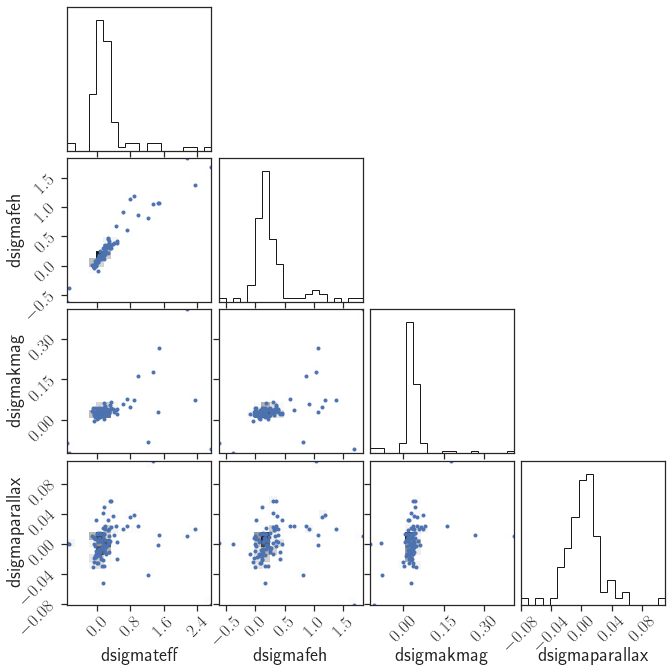

In [7]:
# which parameters could be the most discrepant? (Teff and Fe/H)
import corner
fig = corner.corner(dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
fig = corner.overplot_points(fig, dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])

In [8]:
labels = ["pct_lin", "hdi_lin", "pct_log", "hdi_log"]
data = []
for _d in [dpct, dhdi, dpct_log, dhdi_log]:
    data.append(pd.merge(dast, _d, on='kepid'))

In [20]:
np.sqrt(np.sum(np.array(d[["dsigmateff", "dsigmafeh", "dsigmaparallax"]])**2, axis=1))

array([0.16879028, 0.27166829, 1.08650024, 0.58366626, 1.03075637,
       0.59873241, 0.55277609, 0.83100017, 0.48093449, 0.09750129,
       0.71091993, 0.41921553, 0.45186702, 0.59657359, 0.49587777,
       0.85196268, 0.14784781, 0.34672424, 0.14322953, 1.75500939,
       0.32543674, 0.52077584, 0.10533259, 2.01451174, 0.22247099,
       1.94296231, 1.13824969, 1.92121988, 0.42893532, 0.40424422,
       0.51653841, 0.75641961, 0.56459406, 0.57761294, 0.64390046,
       0.3541924 , 2.75156347, 0.75405215, 3.21159912, 0.66680118,
       0.75673256, 0.52436272, 0.9058703 , 0.66987894, 0.50336511,
       0.64628552, 0.23301829, 0.62798616, 0.51047533, 0.35807472,
       1.15398911, 1.07130261, 0.24453338, 0.57681233, 0.81697362,
       0.66001638, 0.58112981, 0.76997914, 0.18763115, 1.5667393 ,
       0.1653711 , 0.17309619, 0.63990841, 0.7119466 , 0.68261231,
       0.43794689, 0.30273608, 0.93535322, 0.78248466, 0.6512523 ,
       0.29880657, 1.08886089, 1.19028401, 0.21852893, 0.80623

### check bad stars
According to Hall+(2021),
- 8379927, 7510397, 10454113 and 9025370 are SB
- 9139151, 9139163 are wide (visual) binaries

stars with bad isochrone ages have either
- Fe/H<-0.4 (7106245, 9965715)
- SB compnaion (8379927, 9025370)

two of them show bad isochrone fit (7106245, 9025370)

In [19]:
for d,l in zip(data, labels):
    idxbad = (d.iso_age - d.Age) > 4
    print (l)
    print (d[idxbad][['kepid', 'dsigmateff',  'dsigmafeh', 'dsigmaobs', 'feh', 'iso_age', 'Age']])

pct_lin
      kepid  dsigmateff  dsigmafeh  dsigmaobs   feh    iso_age     Age
19  7106245    1.453260   1.071763   1.806002 -0.99  12.762635  6.2732
32  8379927    0.187994   0.269859   0.330279 -0.10   6.076744  1.9943
38  9025370    2.752899   1.680982   3.228284 -0.12  13.246089  6.5458
48  9965715    0.250017   0.218611   0.332682 -0.44  11.173693  2.9206
hdi_lin
      kepid  dsigmateff  dsigmafeh  dsigmaobs   feh    iso_age     Age
19  7106245    1.489936   0.692572   1.643198 -0.99  13.616839  6.2732
38  9025370    2.598214   1.550603   3.040889 -0.12  13.706478  6.5458
48  9965715    0.358480   0.217757   0.429828 -0.44  11.033451  2.9206
pct_log
      kepid  dsigmateff  dsigmafeh  dsigmaobs   feh    iso_age     Age
19  7106245    1.484118   1.065266   1.826867 -0.99  12.633547  6.2732
38  9025370    2.766534   1.703099   3.250873 -0.12  13.205786  6.5458
48  9965715    0.372927   0.303598   0.480891 -0.44  10.961976  2.9206
hdi_log
      kepid  dsigmateff  dsigmafeh  dsigmaobs

In [20]:
for d,l in zip(data, labels):
    idxbad = d.dsigmaobs > 1.5
    print (l)
    print (d[idxbad][['kepid', 'dsigmateff',  'dsigmafeh', 'dsigmaobs', 'feh', 'iso_age', 'Age']])

pct_lin
      kepid  dsigmateff  dsigmafeh  dsigmaobs   feh    iso_age      Age
19  7106245    1.453260   1.071763   1.806002 -0.99  12.762635   6.2732
25  7871531    1.351407   1.040540   1.718309 -0.26  11.892376   9.9633
27  7970740    1.493840   1.065452   1.854171 -0.54  10.724106  12.9817
36  8760414    2.345221   1.376688   2.720542 -0.92  12.914153  11.6642
38  9025370    2.752899   1.680982   3.228284 -0.12  13.246089   6.5458
93  6278762    2.159427   1.829367   2.859559 -0.37  11.371386  11.5400
hdi_lin
       kepid  dsigmateff  dsigmafeh  dsigmaobs   feh    iso_age      Age
19   7106245    1.489936   0.692572   1.643198 -0.99  13.616839   6.2732
22   7510397    1.145220   1.975832   2.284328 -0.21   2.357230   2.8247
25   7871531    1.237479   1.013428   1.625583 -0.26  13.464135   9.9633
27   7970740    1.438099   1.089017   1.840302 -0.54  13.218893  12.9817
36   8760414    2.370168   1.227745   2.670438 -0.92  13.651984  11.6642
38   9025370    2.598214   1.550603   3.04

In [21]:
mlabel = 'seismic mass ($M_\odot$)'
alabel = 'seismic age (Gyr)'
mylabel = 'isochrone $-$ seismic mass ($M_\odot$)'
aylabel = 'isochrone $-$ seismic age (Gyr)'

def plot(d, figname, mth=1.3):
    ms = 5
    fig, ax = plt.subplots(2,2,figsize=(14*1.2,8*1.), sharex='col', sharey='row')

    xkey, astkey, isokey = 'Mass', 'Mass', 'iso_mass'
    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[0,0].errorbar(d[idx][xkey], d[idx][isokey] - d[idx][astkey], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"], d[idx][isokey+"_upp"]], fmt='o', lw=1, markersize=ms,
    label='mass difference: $%.2f\pm%.2f\,M_\odot$'%(np.mean(dy), np.std(dy)))
    ax[0,0].set_ylabel(mylabel)

    xkey, astkey, isokey = 'Mass', 'Age', 'iso_age'
    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[1,0].errorbar(d[idx][xkey], d[idx][isokey] - d[idx][astkey], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"], d[idx][isokey+"_upp"]], fmt='o', lw=1, markersize=ms,
    label='logage difference: $%.2f\pm%.2f\,\mathrm{Gyr}$'%(np.mean(dy), np.std(dy)))
    ax[1,0].set_ylabel(aylabel)
    ax[1,0].set_xlabel(mlabel)

    xkey, astkey, isokey = 'Age', 'Mass', 'iso_mass'
    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[0,1].errorbar(d[idx][xkey][idxm], d[idx][isokey][idxm] - d[idx][astkey][idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]], fmt='o', lw=1, markersize=ms, alpha=1.,label='mass difference: $%.2f\pm%.2f\,M_\odot$'%(np.mean(dy), np.std(dy)))
    idxm = d.Mass>mth
    ax[0,1].errorbar(d[idx][xkey][idxm], (d[idx][isokey] - d[idx][astkey])[idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]],  fmt='o', lw=1, color='C0', alpha=0.3)

    xkey, astkey, isokey = 'Age', 'Age', 'iso_age'
    """
    dy = d[idx][isokey] - d[idx][astkey]
    ax[1,1].errorbar(d[idx][xkey], d[idx][isokey] - d[idx][astkey], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"], d[idx][isokey+"_upp"]], fmt='.', marker='o', lw=1, markersize=ms,
    label='age difference: $%.2f\pm%.2f\,\mathrm{Gyr}$'%(np.mean(dy), np.std(dy)))
    """

    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[1,1].errorbar(d[idx][xkey][idxm], d[idx][isokey][idxm] - d[idx][astkey][idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]], fmt='o', lw=1, markersize=ms, alpha=1.,
    label='age difference: $%.2f\pm%.2f\,\mathrm{Gyr}$'%(np.mean(dy), np.std(dy)))
    idxm = d.Mass>mth
    ax[1,1].errorbar(d[idx][xkey][idxm], (d[idx][isokey] - d[idx][astkey])[idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]], fmt='o', lw=1, color='C0', alpha=0.3)
    ax[1,1].set_xlabel(alabel)

    ax[0,1].legend(loc='upper right')
    ax[1,1].legend(loc='upper right')
    #ax[0,1].set_ylim(-0.33,0.33)
    #ax[1,1].set_ylim(-5, 5)

    for _ax in ax[0]:
        _ax.axhline(y=0, color='gray', alpha=0.5)
    for _ax in ax[1]:
        _ax.axhline(y=0, color='gray', alpha=0.5)

    ax[0,0].yaxis.set_label_coords(-0.075, 0.5)
    ax[1,0].yaxis.set_label_coords(-0.075, 0.5)
    fig.tight_layout(pad=0.15)
    plt.savefig(figname, dpi=200, bbox_inches="tight", facecolor='white')

In [23]:
_d = data[0]
_d[_d['dsigmaobs']>1.5]

,Pipe,KIC,Mass,E_Mass,e_Mass,Rad,E_Rad,e_Rad,log(g),E_log(g),...,dteff,dsigmateff,dfeh,dsigmafeh,dkmag,dsigmakmag,dparallax,dsigmaparallax,dsigmaobs,dsigma
19,BASTA,7106245,0.9214,0.0216,0.0379,1.0959,0.0120,0.0120,4.3254,0.0070,...,159.85860,1.453260,0.107176,1.071763,0.000348,0.031636,-0.000017,-0.001517,1.806002,1.805724
25,BASTA,7871531,0.8287,0.0304,0.0209,0.8707,0.0090,0.0120,4.4781,0.0055,...,148.65475,1.351407,0.104054,1.040540,0.003889,0.176795,0.014364,0.110932,1.718309,1.705586
27,BASTA,7970740,0.7280,0.0304,0.0095,0.7628,0.0060,0.0060,4.5386,0.0055,...,164.32235,1.493840,0.106545,1.065452,0.004798,0.266569,0.000250,0.012159,1.854171,1.834869
36,BASTA,8760414,0.8115,0.0310,0.0186,1.0196,0.0097,0.0121,4.3293,0.0047,...,257.97435,2.345221,0.137669,1.376688,0.000900,0.075000,0.000247,0.019805,2.720542,2.719436
38,BASTA,9025370,0.9693,0.0304,0.0304,1.0027,0.0090,0.0120,4.4231,0.0044,...,302.81885,2.752899,0.168098,1.680982,-0.003071,-0.105914,-0.006244,-0.080306,3.228284,3.225547
93,NaN,6278762,0.7390,0.0090,0.0110,NaN,NaN,NaN,NaN,NaN,...,237.53700,2.159427,0.182937,1.829367,0.008179,0.408967,0.000151,0.010745,2.859559,2.830143


pct_lin
hdi_lin
pct_log
hdi_log


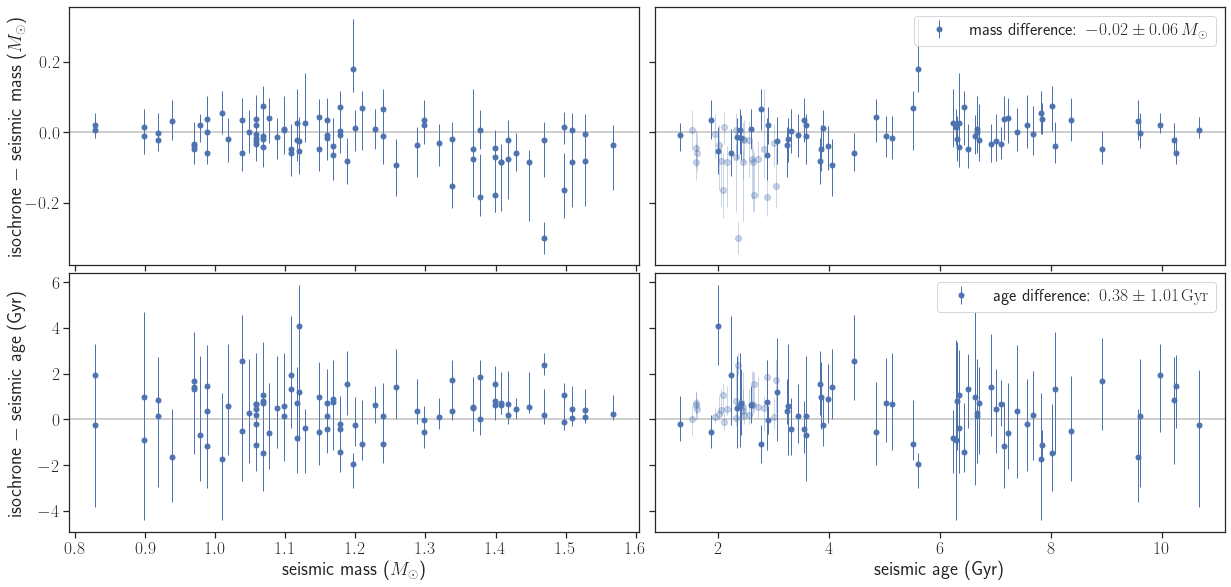

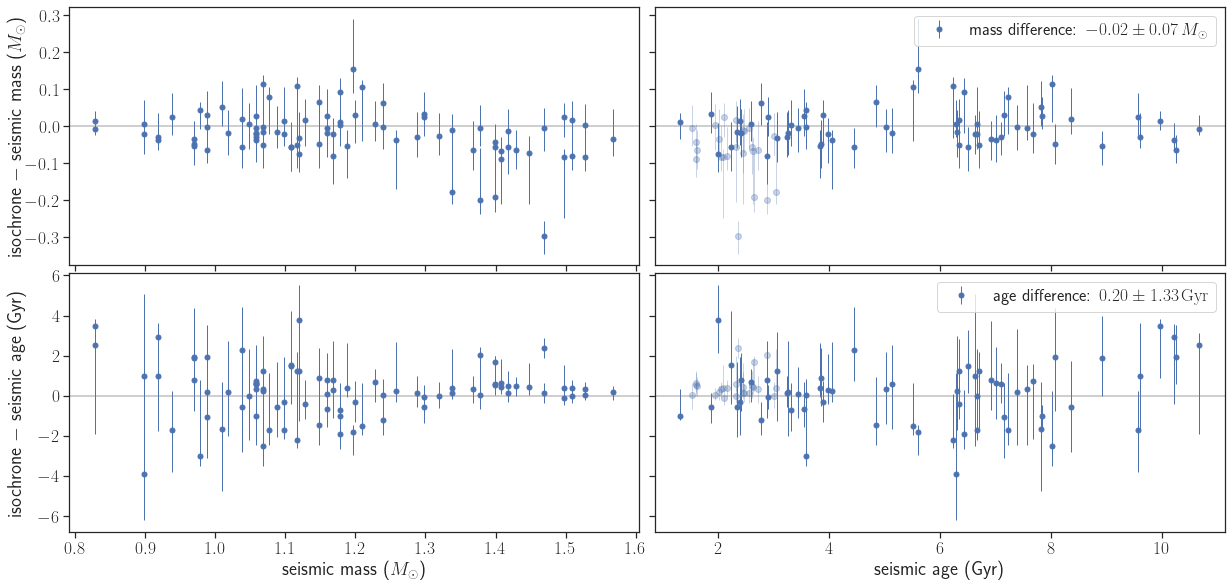

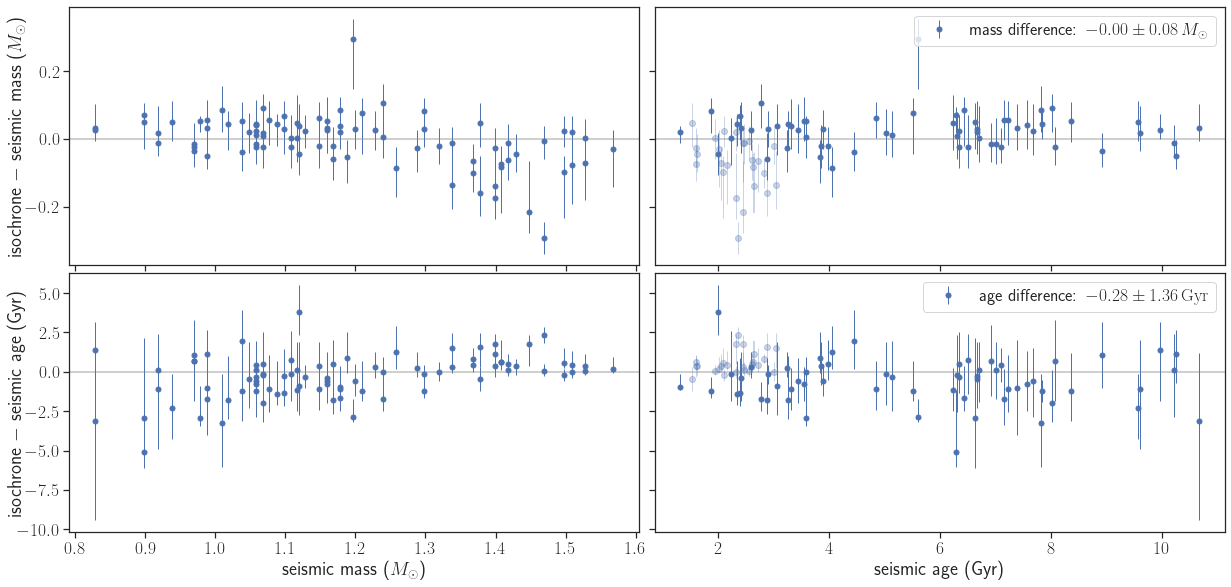

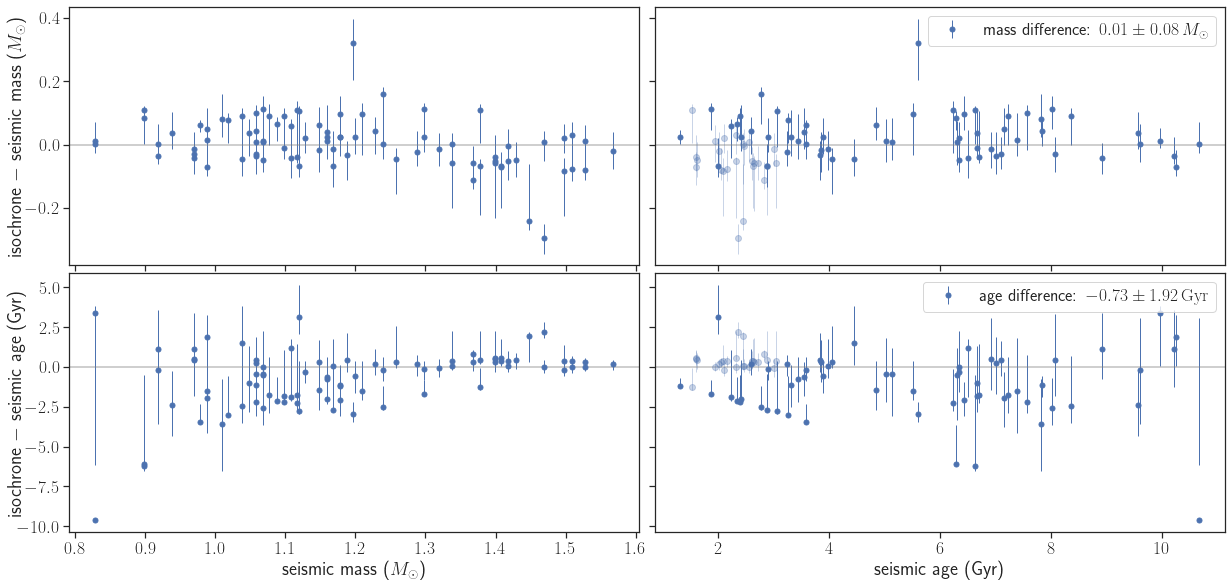

In [26]:
mth = 1.3
for d,l in zip(data, labels):
    #idx = (np.abs(d.dsigmateff)<2.) & (np.abs(d.feh)<0.4)
    idx = (d.dsigmaobs < 2) & (np.abs(d.feh)<0.4)
    figname = l+("_mth%.1f"%mth).replace(".", 'p')
    print (l)
    plot(d, figname)

pct_lin
hdi_lin
pct_log
hdi_log


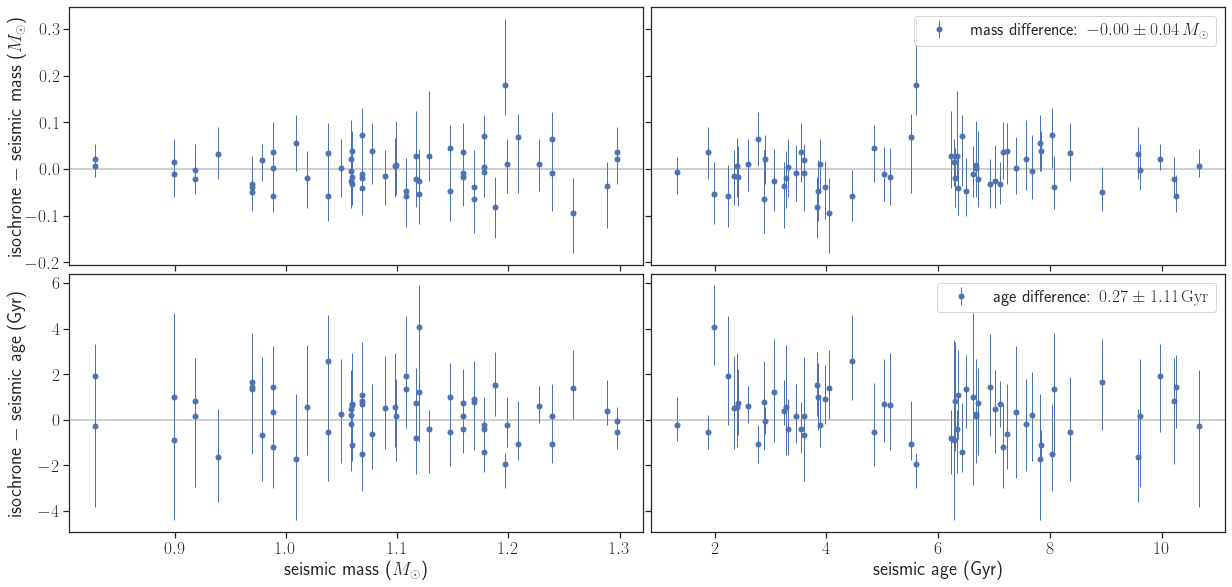

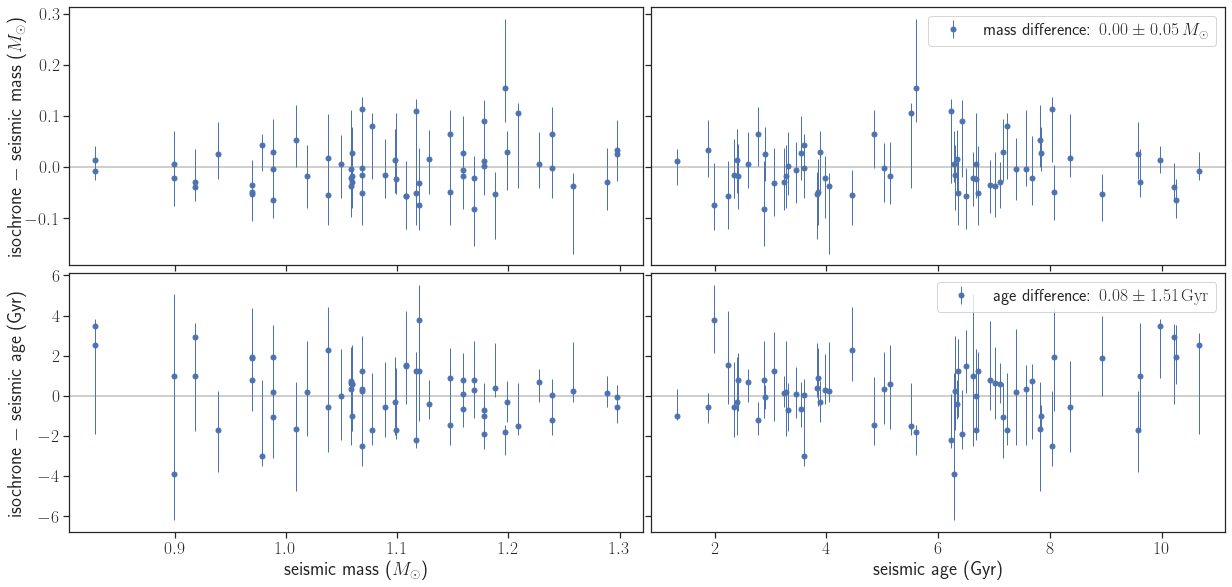

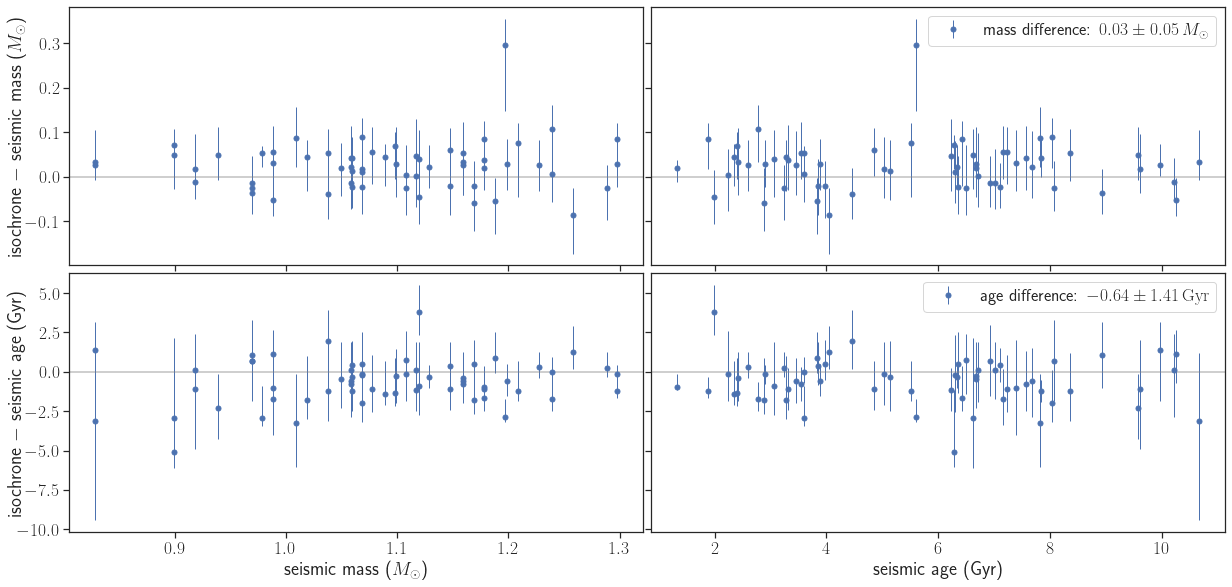

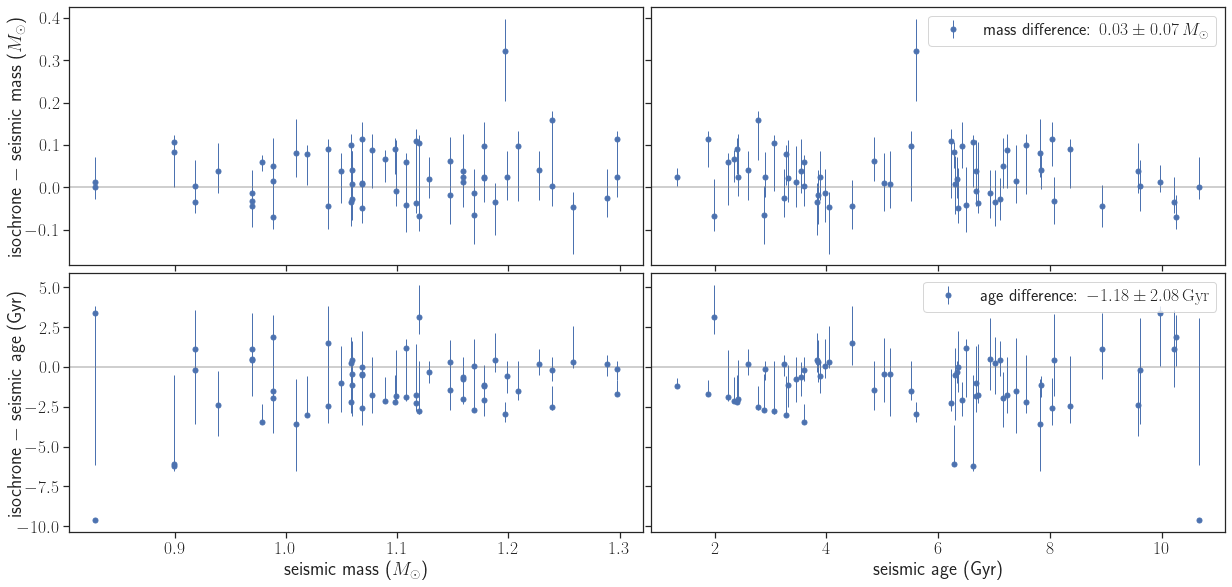

In [28]:
mth = 1.3
for d,l in zip(data, labels):
    #idx = (np.abs(d.dsigmateff)<2.) & (np.abs(d.feh)<0.4) & (d.Mass<mth)
    idx = (d.dsigmaobs < 2) & (np.abs(d.feh)<0.4) & (d.Mass<mth)
    figname = "mcut_" + l
    print(l)
    plot(d, figname)

pct_lin
hdi_lin
pct_log
hdi_log


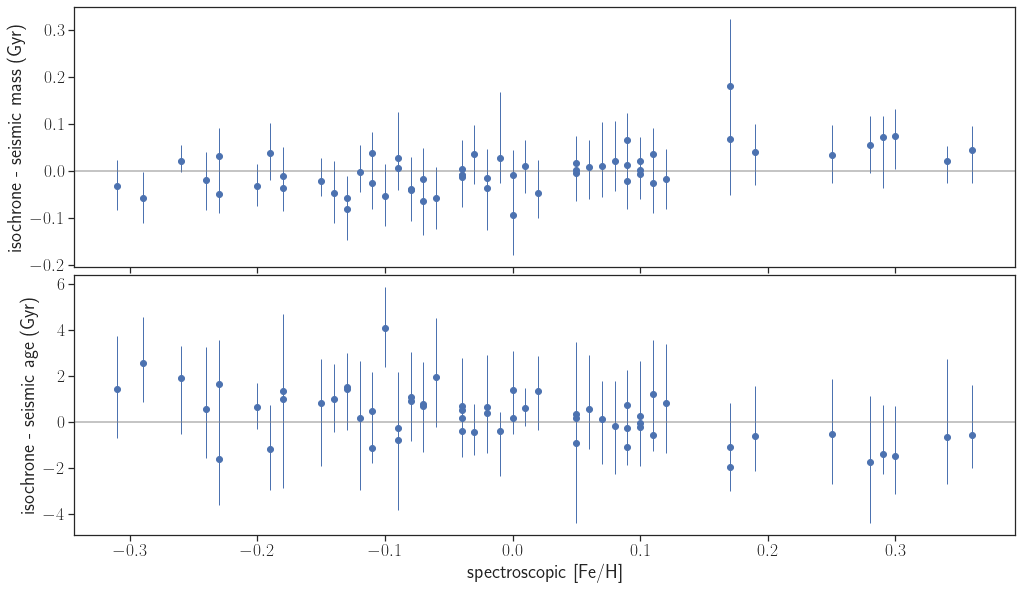

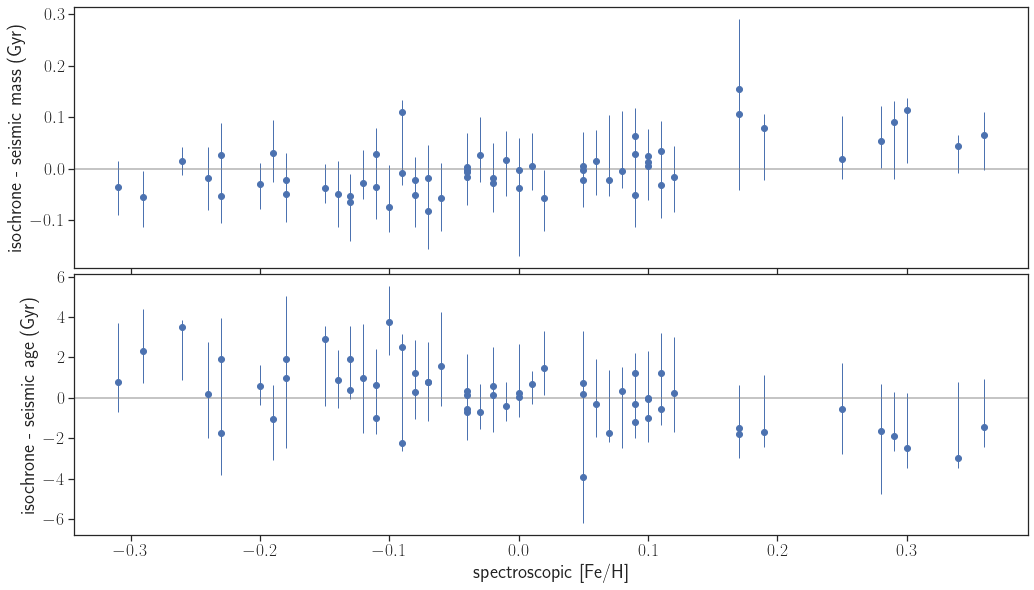

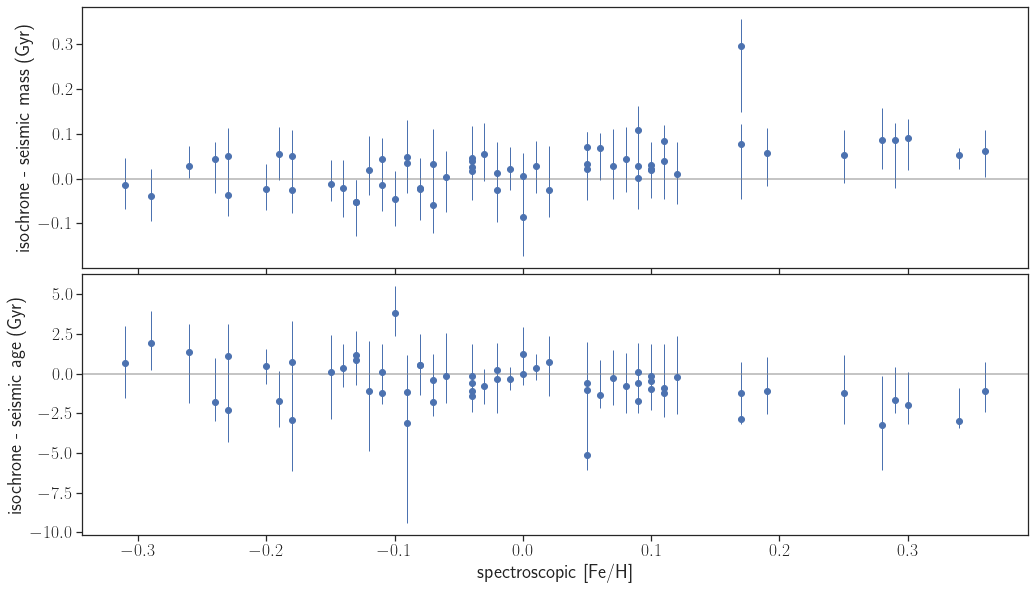

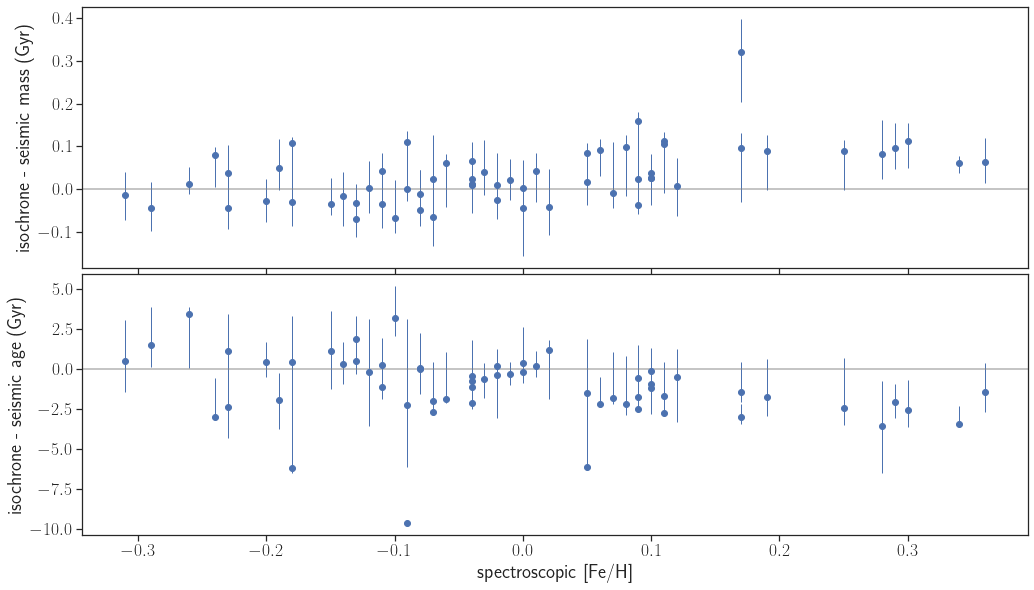

In [29]:
mth = 1.3
for d,l in zip(data, labels):
    print (l)
    
    figname = "feh_mcut_" + l

    #idx = (np.abs(d.dsigmateff)<2.) & (np.abs(d.feh)<0.4) & (d.Mass<mth)
    idx = (d.dsigmaobs < 2) & (np.abs(d.feh)<0.4) & (d.Mass<mth)

    fig, ax = plt.subplots(2, 1, figsize=(14,8), sharex=True)
    ax[1].set_ylabel("isochrone - seismic age (Gyr)")
    #plt.xlabel("spectroscopic [Fe/H]")
    ax[1].errorbar(d[idx].feh, d[idx].iso_age - d[idx].Age, fmt='o', yerr=[d[idx].iso_age_low, d[idx].iso_age_upp], lw=1);
    ax[1].set_xlabel("spectroscopic [Fe/H]")
    ax[1].axhline(y=0, color='gray', alpha=0.6)

    #plt.figure(figsize=(14,7))
    ax[0].set_ylabel("isochrone - seismic mass (Gyr)")
    ax[0].errorbar(d[idx].feh, d[idx].iso_mass - d[idx].Mass, fmt='o', yerr=[d[idx].iso_mass_low, d[idx].iso_mass_upp], lw=1)
    ax[0].axhline(y=0, color='gray', alpha=0.6)

    plt.tight_layout(pad=0.02)
    plt.savefig(figname, dpi=200, bbox_inches="tight")